In [1]:
using Images
using PyPlot
using Grid

include("Common.jl")

export                # exporting for bonus task
loadkeypoints,
euclideansquaredist,
findmatches,
showmatches,
computeransaciterations,
picksamples,
condition,
computehomography,
computehomographydistance,
findinliers,
ransac

#---------------------------------------------------------
# Loads keypoints from JLD container.
#
# INPUTS:
#   filename     JLD container filename
#
# OUTPUTS:
#   keypoints1   [n x 2] keypoint locations (of left image)
#   keypoints2   [n x 2] keypoint locations (of right image)
#
#---------------------------------------------------------
function loadkeypoints(filename::String)

 keypoints1 = load(filename,"keypoints1")
 keypoints2 = load(filename,"keypoints2")

  @assert size(keypoints1,2) == 2
  @assert size(keypoints2,2) == 2
  return keypoints1::Array{Int64,2}, keypoints2::Array{Int64,2}
end


#---------------------------------------------------------
# Compute pairwise Euclidean square distance for all pairs.
#
# INPUTS:
#   features1     [128 x m] descriptors of first image
#   features2     [128 x n] descriptors of second image
#
# OUTPUTS:
#   D             [m x n] distance matrix
#
#---------------------------------------------------------
function euclideansquaredist(features1::Array{Float64,2},features2::Array{Float64,2})
    
    D= zeros(size(features1,2), size(features2,2))
    for i=1:size(features2,2)
        D[:,i]=sum(abs2(features1.-features2[:,i]),1)'   # calculating eucledian distance for each decsriptor against each one
    end

  @assert size(D) == (size(features1,2),size(features2,2))
  return D::Array{Float64,2}
end


#---------------------------------------------------------
# Find pairs of corresponding interest points given the
# distance matrix.
#
# INPUTS:
#   p1      [m x 2] keypoint coordinates in first image.
#   p2      [n x 2] keypoint coordinates in second image.
#   D       [m x n] distance matrix
#
# OUTPUTS:
#   pairs   [min(N,M) x 4] vector s.t. each row holds
#           the coordinates of an interest point in p1 and p2.
#
#---------------------------------------------------------
function findmatches(p1::Array{Int,2},p2::Array{Int,2},D::Array{Float64,2})
    
    no_rows = min(size(p1,1),size(p2,1))
    col = Array{Int64,1}(no_rows) # index for min rows/columns
    pairs = zeros(no_rows,4)    #123*4 min of the number of descriptors of both images as number of rows

if size(p1,1)==no_rows
    for i = 1:no_rows
        col[i] = indmin(D[i,:])
    end
   # p2_points = p2[col,:]  
    pairs = [p1 p2[col,:]]
else
    for i = 1:no_rows
       	col[i] = indmin(D[:,i])
    end 
    pairs = [p1[col,:] p2]
end

  @assert size(pairs) == (min(size(p1,1),size(p2,1)),4)
  return pairs::Array{Int,2}
end


#---------------------------------------------------------
# Show given matches on top of the images in a single figure.
# Concatenate the images into a single array.
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   pairs   [n x 4] vector of coordinates containing the
#           matching pairs.
#
#---------------------------------------------------------
function showmatches(im1::Array{Float64,2},im2::Array{Float64,2},pairs::Array{Int,2})
   
    figure()
    subplot(121)
    imshow(im1,"gray",interpolation="none")
    axis("off")
    scatter(pairs[:,1],pairs[:,2],s=10) #x y coord in 1st and 2nd column respectively
    subplot(122)
    imshow(im2,"gray",interpolation="none")
    axis("off")
    scatter(pairs[:,3],pairs[:,4],s=10)
  return nothing::Void
end


#---------------------------------------------------------
# Computes the required number of iterations for RANSAC.
#
# INPUTS:
#   p    probability that any given correspondence is valid
#   k    number of samples drawn per iteration
#   z    total probability of success after all iterations
#
# OUTPUTS:
#   n   minimum number of required iterations
#
#---------------------------------------------------------
function computeransaciterations(p::Float64,k::Int,z::Float64)
  
    
     n1=log((1-z))
     n2=log(1-p^k)
     n=Int(ceil(n1/n2))   


  return n::Int
end


#---------------------------------------------------------
# Randomly select k corresponding point pairs.
#
# INPUTS:
#   points1    given points in first image
#   points2    given points in second image
#   k          number of pairs to select
#
# OUTPUTS:
#   sample1    selected [kx2] pair in left image
#   sample2    selected [kx2] pair in right image
#
#---------------------------------------------------------
function picksamples(points1::Array{Int,2},points2::Array{Int,2},k::Int)
    n = size(points1,1)
    random = rand(1:n,k)  # generates k=4 random numbers between 1 to 123
   
    sample1 = points1[random,:]
    sample2 = points2[random,:]

  @assert size(sample1) == (k,2)
  @assert size(sample2) == (k,2)
  return sample1::Array{Int,2},sample2::Array{Int,2}
end


#---------------------------------------------------------
# Conditioning: Normalization of coordinates for numeric stability.
#
# INPUTS:
#   points    unnormalized coordinates
#
# OUTPUTS:
#   U         normalized (conditioned) coordinates
#   T         [3x3] transformation matrix that is used for
#                   conditioning
#
#---------------------------------------------------------
function condition(points::Array{Float64,2})

    Tx = mean(points[:,1])
    Ty = mean(points[:,2])
    
    pointsC = Common.cart2hom(points')
    S = 0.5*maximum(sqrt(abs2(pointsC[:,1])+abs2(pointsC[:,2])))   # transformation matrix values for  set of points
    T = [1/S 0 -Tx/S ; 0 1/S -Ty/S; 0 0 1]    # transformation matrices
    U = T*pointsC #trasnformed  points
    U = Common.hom2cart(U)'
    
  @assert size(U) == size(points)
  @assert size(T) == (3,3)
  return U::Array{Float64,2},T::Array{Float64,2}
end


#---------------------------------------------------------
# Estimates the homography from the given correspondences.
#
# INPUTS:
#   points1    correspondences in left image
#   points2    correspondences in right image
#
# OUTPUTS:
#   H         [3x3] estimated homography
#
#---------------------------------------------------------
function computehomography(points1::Array{Int,2}, points2::Array{Int,2})
    
    
    p1_float = convert(Array{Float64,2},copy(points1))
    p2_float = convert(Array{Float64,2},copy(points2))
    
    
    sample1,T = condition(p1_float)
    sample2,Tp = condition(p2_float)
    
    sample1C = Common.cart2hom(sample1')
    sample2C = Common.cart2hom(sample2')
  
    j = 1
    p = Array{Float64}(2*size(points1,1),9)
    for i = 1:size(points1,1)
        p[j,:] = [0 0 0 sample1C[:,i]' sample1C[:,i]'.*(-sample2C[2,i])]
        p[j+1,:] = [sample1C[:,i]'.*-1 0 0 0  sample1C[:,i]'.*(sample2C[1,i])]
        j=j+2
    end
    
   
    _,_,V=svd(p,thin=false)
   
    H = reshape(V[:,end],3,3).'
   
     H = inv(Tp)*H*T   # reverse normalise only the final homography
    
  @assert size(H) == (3,3)
  return H::Array{Float64,2}
end


#---------------------------------------------------------
# Computes distances for keypoints after transformation
# with the given homography.
#
# INPUTS:
#   H          [3x3] homography
#   points1    correspondences in left image
#   points2    correspondences in right image
#
# OUTPUTS:
#   d2         distance measure using the given homography
#
#---------------------------------------------------------
function computehomographydistance(H::Array{Float64,2},points1::Array{Int,2},points2::Array{Int,2})
    
    points1C = Common.cart2hom(points1')
    points2C = Common.cart2hom(points2')
    
    no_rows = size(points1,1)
    left_proj = Array{Float64,1}
    right_proj = Array{Float64,1}
    d2 = Array{Float64,2}(no_rows,1) 

    for i=1:no_rows
            left_proj = H*points1C[:,i]  ## projection of left points          
            right_proj = inv(H)*points2C[:,i]  ## projection of right points  
            
            left_proj = left_proj./left_proj[end]   #norma;ize the x y value
            right_proj = right_proj./right_proj[end]
            
            d2[i,1] = sum(abs2(points1C[:,i]-right_proj)) + sum(abs2(left_proj-points2C[:,i]))   
    end
   

  @assert length(d2) == size(points1,1)
  return d2::Array{Float64,2}
end


#---------------------------------------------------------
# Compute the inliers for a given distances and threshold.
#
# INPUTS:
#   distance   homography distances
#   thresh     threshold to decide whether a distance is an inlier
#
# OUTPUTS:
#  n          number of inliers
#  indices    indices (in distance) of inliers
#
#---------------------------------------------------------
function findinliers(distance::Array{Float64,2},thresh::Float64)
    
    indices = zeros(Int,size(distance,1))

    distance = distance.*(distance.<thresh)   # makes all the elemenst 0 which are less than threshold
    n = 1
    for i = 1:size(distance,1)
        if distance[i]>0
           indices[n] = i
           n = n+1                   
        end 
    end
    n=n-1

    typeof(indices)
  return n::Int,indices::Array{Int,1}
end


#---------------------------------------------------------
# RANSAC algorithm.
#
# INPUTS:
#   pairs     potential matches between interest points.
#   thresh    threshold to decide whether a homography distance is an inlier
#   n         maximum number of RANSAC iterations
#
# OUTPUTS:
#   bestinliers   [n x 1 ] indices of best inliers observed during RANSAC
#
#   bestpairs     [4x4] set of best pairs observed during RANSAC
#                 i.e. 4 x [x1 y1 x2 y2]
#
#   bestH         [3x3] best homography observed during RANSAC
#
#---------------------------------------------------------
function ransac(pairs::Array{Int,2},thresh::Float64,n::Int)

 points1 = pairs[:,1:2]
 points2 = pairs[:,3:4]
 no_rows = size(pairs,1)

 bestH = Array{Float64,2}(3,3)
 best_count = 0
 bestinliers = Array{Int}(no_rows)
 bestpairs = Array{Int}(4,4)
 count = 0 #no. of inliers
 k=4  
 indices = zeros(Int,no_rows)   ## gives 1D indices...points are 2D though  
 

 for loop=1:n  #maximum number of RANSAC iterations
        
  sample1,sample2 = picksamples(points1,points2,k)
    
  H = computehomography(sample1,sample2)
  #if determinant is 0 inv(H) is not defined and hence that iteration is skipped
  #when sample points picked randomly are same for one of the images det=0
  if det(H)!=0  
     d2 = computehomographydistance(H,points1,points2)
    
     count, indices = findinliers(d2,thresh)

     if count>best_count
        best_count = count
        bestinliers = indices
        bestH = H
        bestpairs = [sample1 sample2]
     end

   else
      loop=loop-1  # conserving the failed attempts
  end      
 end 

   bestinliers=bestinliers[1:best_count]
  @assert size(bestinliers,2) == 1
  @assert size(bestpairs) == (4,4)
  @assert size(bestH) == (3,3)
  return bestinliers::Array{Int,1},bestpairs::Array{Int,2},bestH::Array{Float64,2}
end


#---------------------------------------------------------
# Recompute the homography based on all inliers
#
# INPUTS:
#   pairs     pairs of keypoints
#   inliers   inlier indices.
#
# OUTPUTS:
#   H         refitted homography using the inliers
#
#---------------------------------------------------------
function refithomography(pairs::Array{Int64,2}, inliers::Array{Int64,1})

    points1 = pairs[inliers,1:2]
    points2 = pairs[inliers,3:4]
    H = computehomography(points1,points2)
        
  @assert size(H) == (3,3)
  return H::Array{Float64,2}
end


#---------------------------------------------------------
# Show panorama stitch of both images using the given homography.
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   H       [3x3] estimated homography between im1 and im2
#
#---------------------------------------------------------
function showstitch(im1::Array{Float64,2},im2::Array{Float64,2},H::Array{Float64,2})
    grid = Grid.InterpGrid(im2,0,InterpLinear) #fill with 0 if no value found
    #im3 = grid[1:299,1:700]
    x = 1:700 #x axis but column of the image
    y = 1:299 #y axis but row of the image

    trans_img = zeros(299,700)
    trans_coord = Array{Float32}(3)
    k=1
 
#We tried first transforming the im2 directly to image1 plane (inv(H)*img2) but since some indexes calculated were negative and some were in decimal points rounding them was causing discrepancy
#the transformed image had several pixels which were not getting any value and hence appeared as black dots
# so instead, we calculated for each point of the transformed image the coord of img2
#As using Grid function InterpGrid  all indexes of img2 were interpolated
#All pixels of transformed image was well defined and no value was missing


    for i in x
        for j in y
         trans_coord[:] = H*[i ;j ;1 ] #find coord of  2nd image [x y 1]
        
         trans_coord[:] = trans_coord[:]./trans_coord[3]
         trans_img[j,i] = grid[trans_coord[2],trans_coord[1]] 
      
        k=k+1
        end
    end
        
   final_image = zeros(299,700)
   final_image = [im1[:,1:300] trans_img[:,301:700]]
   figure()
   imshow(trans_img,"gray")
   title("Transformed image")
   figure()
   imshow(final_image,"gray",interpolation="none")
  
  return nothing::Void
end


#---------------------------------------------------------
# Bonus task 1-blending the panorama image smoothly
#
# INPUTS:
#   im1     first grayscale image
#   im2     second grayscale image
#   H       [3x3] estimated homography between im1 and im2
#
#---------------------------------------------------------
function blending(im1::Array{Float64,2},im2::Array{Float64,2},H::Array{Float64,2})
    
####### #################################Explanation########################################################################

    #=The two images that we have used for panorama are of similar kind of scenes but have different exposure level
#The right image is more exposed as compared to the left one
#We first calculate the mean exposure of the left image as well as the transfomed right image in the left's plane.
#We then multiply the individual image pixel intensity of the left image with  the ratio of the mean intensity of right as well as left image. This process helps us in making both the images to the same exposure level.

#Even after doing this we find that the transition between the left and right image in the panorama is not smooth. To make the transition smoother we use  weighted averaging in the middle 33% portion of the image.
    #We found that if we take 98% pixel values from the left image and 2% pixel value from the trasformed(right image in left's plane) in this transition region and if we merge it with the remaining 66% of the image we get a very smooth transition =#  
 
      
 ############################################################################################################################  
    
    
    grid = Grid.InterpGrid(im2,0,InterpLinear) #fill with 0 if no value found
    
    x = 1:700 #x axis but column of the image
    y = 1:299 #y axis but row of the image

    trans_img = zeros(299,700)
    trans_coord = Array{Float32}(3)
    k=1
 
    for i in x
        for j in y
         trans_coord[:] = H*[i ;j ;1 ] #find coord of  2nd image [x y 1]
        
         trans_coord[:] = trans_coord[:]./trans_coord[3]
         trans_img[j,i] = grid[trans_coord[2],trans_coord[1]] 
      
        k=k+1
        end
    end
          
    final_blending=zeros(299,700)

    avg_I_left=(mean(im1[:,1:400]))
    avg_I_right=(mean(trans_img[:,300:700]))

    temp=im1.*(avg_I_left/avg_I_right)  ## change the exposure of each pixel in image 1 by the ratio of average Intensity of both 							the images

    blend_portion= 0.98*temp[:,251:400]+ 0.03*trans_img[:,251:400]  # blended 1/3rd of the image with components from both images

   final_blending = [temp[:,1:250] blend_portion trans_img[:,401:700]]


   figure()
   imshow(final_blending,"gray",interpolation="none")
    
    
   ############################################# 

   
  return nothing::Void
      
end








blending (generic function with 1 method)

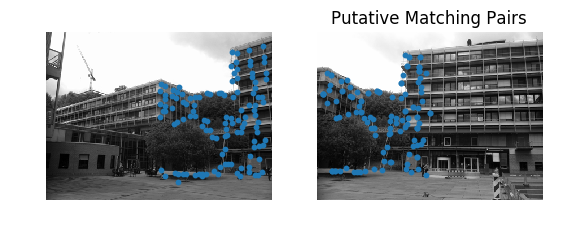

PyObject <matplotlib.text.Text object at 0x7fd2e01a94d0>

In [2]:

#---------------------------------------------------------
# Image Stitching
#---------------------------------------------------------

  # SIFT Parameters
  sigma = 1.4             # standard deviation for presmoothing derivatives

  # RANSAC Parameters
  ransac_threshold = 50.0 # inlier threshold
  p = 0.5                 # probability that any given correspondence is valid
  k = 4                   # number of samples drawn per iteration
  z = 0.99                # total probability of success after all iterations

  # load images
  im1 = PyPlot.imread("a3p2a.png")
  im2 = PyPlot.imread("a3p2b.png")

  # Convert to double precision
  im1 = Float64.(im1)
  im2 = Float64.(im2)

  # load keypoints
  keypoints1, keypoints2 = loadkeypoints("keypoints.jld")

  # extract SIFT features for the keypoints
  features1 = Common.sift(keypoints1,im1,sigma)
  features2 = Common.sift(keypoints2,im2,sigma)

   
  # compute chi-square distance  matrix
  D = euclideansquaredist(features1,features2)

  #display("D")
  #display(D)
  # find matching pairs
  pairs = findmatches(keypoints1,keypoints2,D)

  # show matches
  showmatches(im1,im2,pairs)
  title("Putative Matching Pairs")


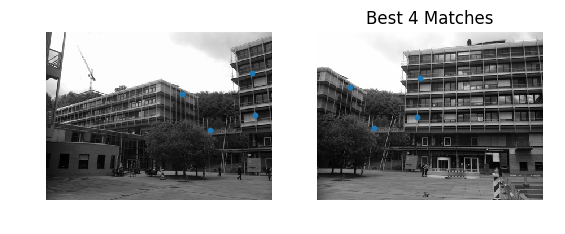

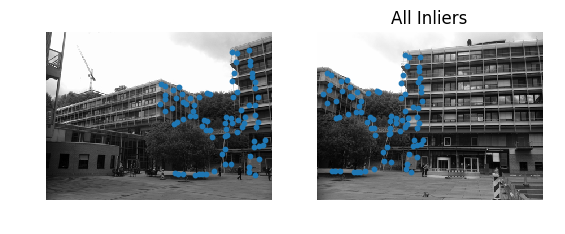

PyObject <matplotlib.text.Text object at 0x7fd2dff857d0>

In [3]:

  # compute number of iterations for the RANSAC algorithm
  niterations = computeransaciterations(p,k,z)
 
  # apply RANSAC
  bestinliers,bestpairs,bestH = ransac(pairs,ransac_threshold,niterations)
  #d1 = computehomographydistance(bestH,pairs[bestinliers,1:2],pairs[bestinliers,3:4])
  #display("no of inliers")
  #display(size(bestinliers))
  # show best matches
  showmatches(im1,im2,bestpairs)
  title("Best 4 Matches")


  # show all inliers
  showmatches(im1,im2,pairs[bestinliers,:])
  title("All Inliers")






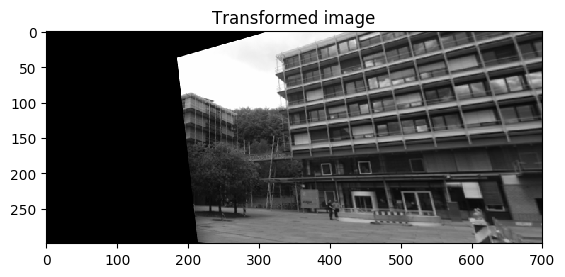

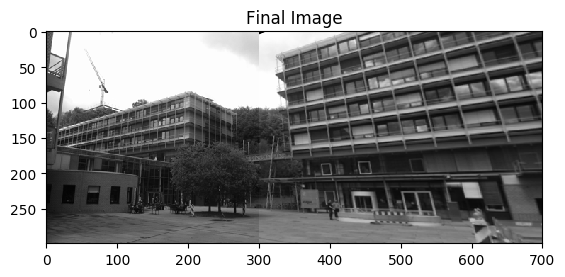

3×3 Array{Float64,2}:
 -0.346077      0.0386536   62.2209  
 -0.0853595    -0.304891    25.5945  
 -0.000365506   9.70591e-6  -0.203828

In [4]:

  # stitch images and show the result
   showstitch(im1,im2,bestH)
   title("Final Image")
  # recompute homography with all inliers
  H = refithomography(pairs,bestinliers)
  #d2 = computehomographydistance(H,pairs[bestinliers,1:2],pairs[bestinliers,3:4])
  
 

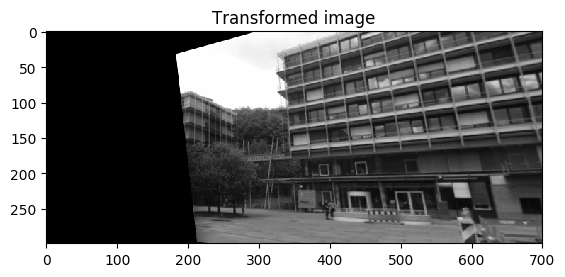

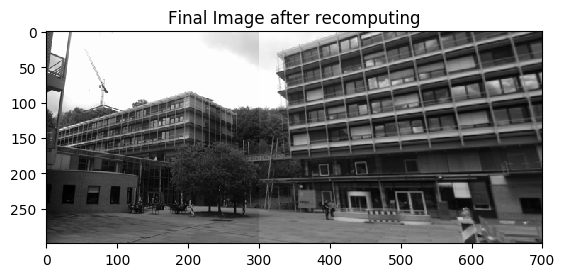

PyObject <matplotlib.text.Text object at 0x7fd2dfc45910>

In [5]:
 showstitch(im1,im2,H)
  title("Final Image after recomputing")
    
 

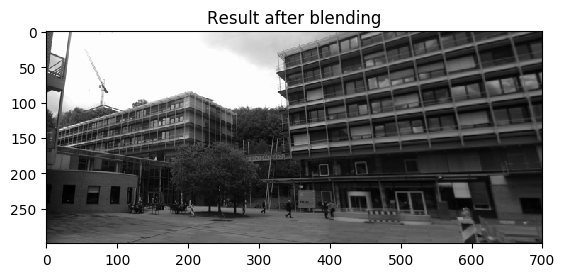

PyObject <matplotlib.text.Text object at 0x7fd2dfb15e90>

In [6]:
 blending(im1,im2,H)    ## function added to improve blending as a part of bonus excercise
 title("Result after blending")  
    
